# 03. Классификация

Содержание:
- Постановка задачи классификации
    - бинарная классификация
    - мультиклассовая классификация
- Оценка качества классификатора
    - precision
    - recall
    - accuracy
    - f1
    - дисбаланс классов
- Методы классификации
    - логистическая регрессия
    - деревья решений
    - catboost
- Ссылки для дальнейшего изучения.

## 1. Постановка задачи классификации

_Классификация_ $-$ это предсказание класса (метки) для объекта по его признакам.

> Примеры:
> - Спам/не спам в почте.
> - Болен/здоров по анализам.
> - К какому виду относится цветок по фотографии.

Разновидности классификации по количеству классов:
- Бинарная классификация: 2 класса (например, `спам` vs `не спам`).
- Мультиклассовая классификация: 3 и более классов.

## 2. Оценка качества классификатора

Базовые понятия в случае бинарной классификации.
У нас два класса: 1 (или положительный класс) и 0 (или отрицательный класс). Тогда варианты для предсказания метки класса следующие:
- TP (True Positive) $-$ модель верно предсказала класс 1.
- TN (True Negative) $-$ модель верно предсказала класс 0.
- FP (False Positive) $-$ модель ошибочно предсказала класс 1 (ложная тревога, ошибка первого рода).
- FN (False Negative) $-$ модель ошибочно предсказала класс 0 (пропуск, ошибка второго рода).

![](https://www.tutorialspoint.com/assets/questions/media/661458-1692780414.png)

Метрики:
- Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ $-$ доля верных среди всех предсказаний
- Precision = $\frac{TP}{TP + FP}$ $-$ доля верных среди предсказанных положительных
- Recall = $\frac{TP}{TP + FN}$ $-$ доля найденных среди всех истинно положительных
- F1 = $2\frac{Precision · Recall}{Precision + Recall}$ $-$ баланс Precision и Recall

### Проблема дисбаланса классов

_Дисбаланс_ классов возникает, когда в данных один класс представлен существенно больше, чем другой (например, 99% объектов одного класса и 1% — другого).

> Проблема:
> Модель, которая _всегда_ предсказывает большой класс, может иметь высокую Accuracy, но на практике она бесполезна,
> так как не умеет находить меньший класс (например, мошеннические операции или редкие заболевания).


Что делать?
- Использование подходящих метрик: Вместо Accuracy используйте Precision, Recall, F1-Score или ROC-AUC, которые менее чувствительны к дисбалансу.
- Взвешивание классов: Многие алгоритмы позволяют назначать больший "штраф" за ошибку на объектах меньшего класса.
- Сэмплирование:
    - "Недосэмплирование": Случайное удаление части объектов большого класса
    - "Пересэмплирование": Искусственное увеличение количества объектов миноритарного класса (например, дублирование или генерация синтетических примеров)

> **Важно!** Не всегда нужно бороться с дисбалансом. Если модель хорошо ранжирует объекты (то есть присваивает объектам меньшего класса более высокие вероятности), а вас интересуют именно вероятности, то дисбаланс может быть не страшен.

## 3. Методы классификации

Рассмотрим различные методы классификации:
- Логистическая регрессия
- Деревья решений
- Catboost

In [1]:
# Вспомогательные функции для визуализации и оценки

import numpy as np

def plot_decision_boundary(ax, model, X, y, title=""):
    # Сетка точек по двум признакам
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Фон — предсказанные классы
    ax.contourf(xx, yy, Z, alpha=0.25, cmap=plt.cm.Set3)

    # Точки
    scatter = ax.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Set1, edgecolor='k', s=35)
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

def print_binary_metrics(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    print(f"{name}: accuracy={acc:.3f}, precision={prec:.3f}, recall={rec:.3f}, f1={f1:.3f}")

### Логистическая регрессия

Несмотря на название, это _линейный классификатор_, а не регрессор. Он предсказывает _вероятность_ того, что объект принадлежит к определенному классу. Для этого используется _сигмоидная функция_ (логистическая функция), которая "сжимает" линейную комбинацию признаков в число от 0 до 1.

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

> Многомерный случай:
> 
> $$\sigma(\mathbf{W}\mathbf{x} + \mathbf{b}) = \frac{1}{1 + e^{-(\mathbf{W}\mathbf{x} + \mathbf{b})}}$$

Алгоритм строит линейную границу принятия решений. Если предсказанная вероятность больше или равна 0.5, объект относится к классу 1, иначе $-$ к классу 0.

![](https://images.spiceworks.com/wp-content/uploads/2022/04/11040521/46-4-e1715636469361.png)


Плюсы:
- Быстрая, понятная

Минусы:
- Плоха на сложных нелинейных зависимостях (если не добавить признаки)

#### Пример

Допустим, мы хотим предсказать, купит ли клиент товар, на основе его возраста и времени, проведенного на сайте.

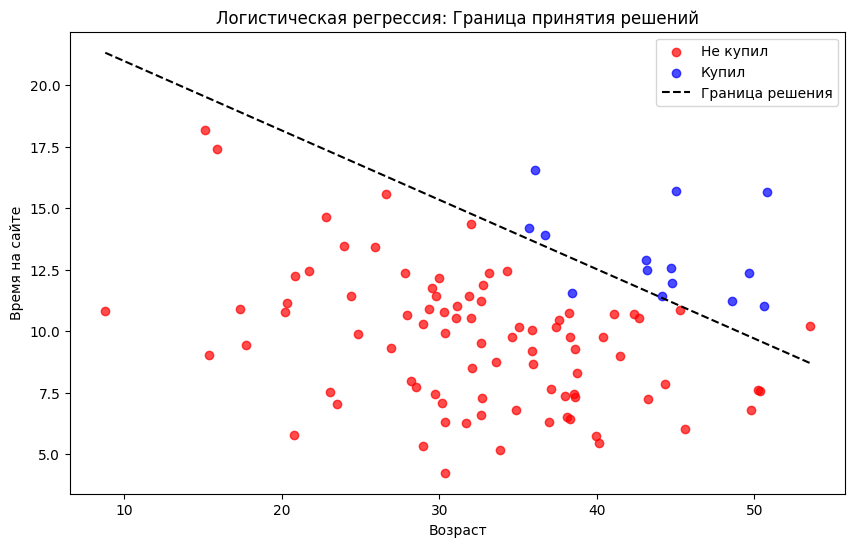

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Сгенерируем синтетические данные
np.random.seed(42)
age = np.random.normal(35, 10, 100) # Возраст
time_on_site = np.random.normal(10, 3, 100) # Время на сайте

# Создаем целевую переменную: 1 если покупка была, 0 если нет
# (логика: вероятность покупки выше у старших и тех, кто дольше на сайте)
purchase = ((age > 40) & (time_on_site > 12) | (age > 35) & (time_on_site > 11)).astype(int)

# Обучаем модель
X = np.column_stack((age, time_on_site))
model = LogisticRegression()
model.fit(X, purchase)

# Визуализация
plt.figure(figsize=(10, 6))
plt.scatter(age[purchase==0], time_on_site[purchase==0], c='red', label='Не купил', alpha=0.7)
plt.scatter(age[purchase==1], time_on_site[purchase==1], c='blue', label='Купил', alpha=0.7)

# Строим границу решения
coef = model.coef_[0]
intercept = model.intercept_

age_range = np.linspace(age.min(), age.max(), 100)
decision_boundary = -(coef[0] * age_range + intercept) / coef[1] # Решаем уравнение w*x + b = 0

plt.plot(age_range, decision_boundary, 'k--', label='Граница решения')
plt.xlabel('Возраст')
plt.ylabel('Время на сайте')
plt.legend()
plt.title('Логистическая регрессия: Граница принятия решений')
plt.show()

### Деревья решений

Алгоритм строит модель в виде древовидной структуры. Каждый внутренний узел дерева проверяет определенный признак, каждая ветвь $-$ результат проверки, а каждый лист $-$ метка класса.

![](https://www.insidealgorithms.com/wp-content/uploads/2024/05/decision-tree-featured_image-1024x576.png.webp)

Начиная с корня, дерево задает вопросы о признаках объекта. В зависимости от ответа объект спускается по соответствующей ветви до тех пор, пока не достигнет листа, который и укажет предсказанный класс.

Плюсы:
- Интерпретируемость

Минусы:
- Легко переобучается (нужны ограничения глубины, pruning)

#### Пример

Попробуем классифицировать животных по двум признакам: "Имеет перья?" и "Умеет летать?".

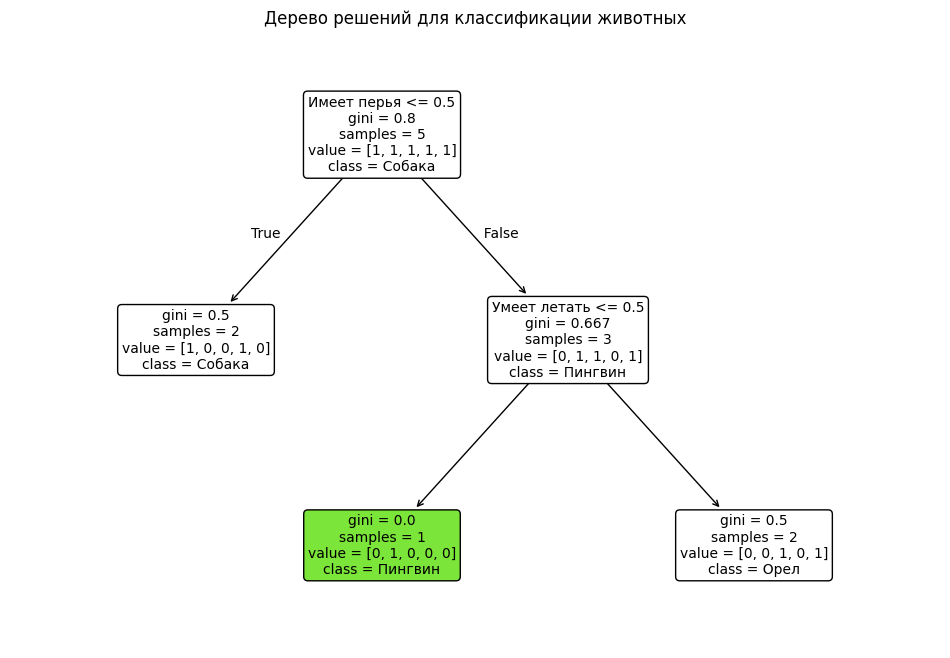

In [3]:
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt

# Данные: [Имеет_перья, Умеет_летать]
features = [[0, 0], [1, 0], [1, 1], [0, 0], [1, 1]] # 0 - Нет, 1 - Да
labels = ['Собака', 'Пингвин', 'Орел', 'Кот', 'Попугай'] # Метки классов

# Преобразуем в pd.Series перед факторизацией
label_series = pd.Series(labels)
label_ids, unique_labels = pd.factorize(label_series)

# Обучаем модель
clf = tree.DecisionTreeClassifier()
clf.fit(features, label_ids)

# Визуализируем дерево
plt.figure(figsize=(12, 8))
tree.plot_tree(clf,
               feature_names=['Имеет перья', 'Умеет летать'],
               class_names=unique_labels,
               filled=True,
               rounded=True,
               fontsize=10)
plt.title("Дерево решений для классификации животных")
plt.show()

#### Другой пример

Сначал применим логистическую регрессию, а потом деревья решений, и посмотрим, чем отличается разделение (границы классов).

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

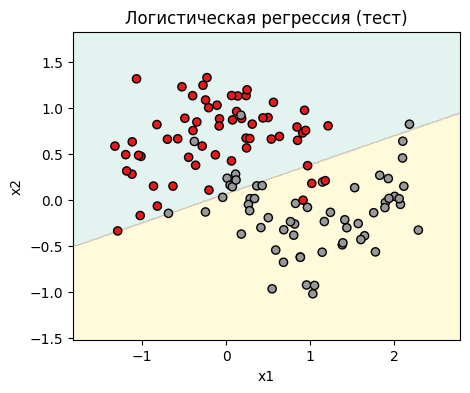

Логистическая регрессия: accuracy=0.900, precision=0.944, recall=0.850, f1=0.895


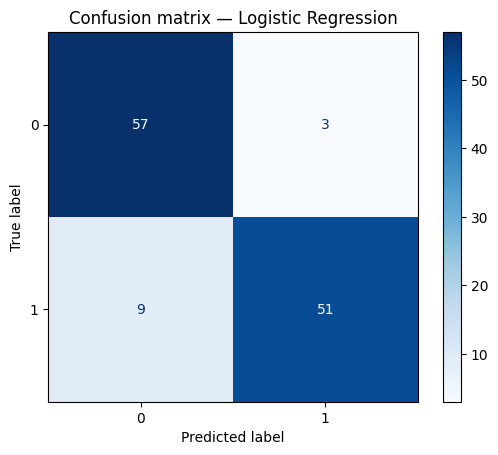

In [5]:
# Данные в виде двух полумесяцев (две луны): нелинейно разделимы
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

# Разделим на обучение/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Пайплайн: масштабирование + логистическая регрессия
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(random_state=42))
])
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Визуализация и метрики
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, logreg, X_test, y_test, title="Логистическая регрессия (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_lr, name="Логистическая регрессия")

# Матрица ошибок
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test, cmap="Blues")
plt.title("Confusion matrix — Logistic Regression")
plt.show()

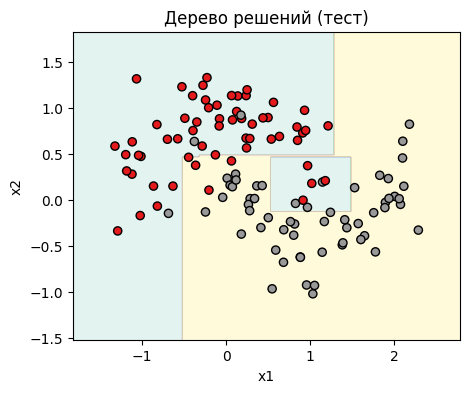

Дерево решений: accuracy=0.925, precision=0.947, recall=0.900, f1=0.923


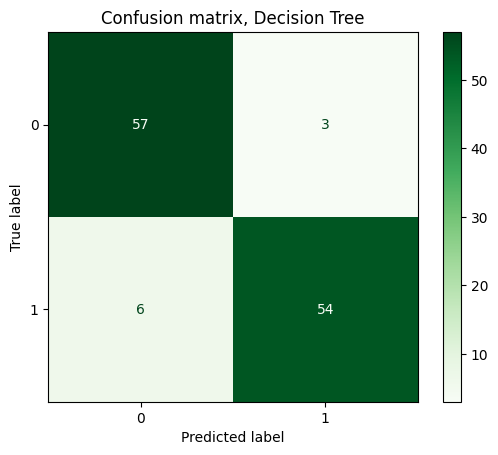

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, tree, X_test, y_test, title="Дерево решений (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_tree, name="Дерево решений")

ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, cmap="Greens")
plt.title("Confusion matrix, Decision Tree")
plt.show()

### Catboost

CatBoost $-$ это мощный алгоритм, основанный на _градиентном бустинге_ (обучение ансамбля деревьев, где каждое следующее дерево исправляет ошибки предыдущих).
Его ключевая особенность $-$ он отлично работает с категориальными признаками без их предварительной обработки (например, не нужно переводить текстовые метки в числа с помощью [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)).


CatBoost строит множество деревьев последовательно. На каждом шаге он строит новое дерево, которое предсказывает не итоговый ответ, а ошибку предыдущего ансамбля. Так модель постепенно учится исправлять свои недочеты.

Идея:
- Ансамбль многих деревьев, каждое дерево исправляет ошибки предыдущих.
- Отлично работает "из коробки"; хорошо справляется с категориальными признаками (кодирование внутри).

Плюсы:
- Высокое качество, мало ручной подготовки признаков.

Минусы:
- Более тяжелый по времени/ресурсам, больше параметров для настройки.

#### Пример

Допустим, у нас есть данные о книгах: _жанр_ (категориальный признак), _количество страниц_ (числовой признак) и _рейтинг (целевая переменная: "Низкий", "Средний", "Высокий").

In [7]:
from catboost import CatBoostClassifier, Pool

# Данные
data = {
    'Жанр': ['Фэнтези', 'Детектив', 'Наука', 'Фэнтези', 'Детектив'], # Категориальный признак
    'Страницы': [450, 300, 600, 200, 400] # Числовой признак
}
df = pd.DataFrame(data)

# Целевая переменная (мультикласс)
target = ['Высокий', 'Средний', 'Высокий', 'Низкий', 'Средний']

# Создаем объект Pool, явно указывая категориальные признаки
train_pool = Pool(data=df, label=target, cat_features=['Жанр']) # 'Жанр' - категориальный!

# Обучаем модель CatBoost
model = CatBoostClassifier(iterations=100, verbose=False)
model.fit(train_pool)

# Предсказание для новой книги
new_book = pd.DataFrame({'Жанр': ['Наука'], 'Страницы': [550]})
prediction = model.predict(new_book)
pred_proba = model.predict_proba(new_book)

print(f"Предсказанный рейтинг: {prediction[0]}")
print(f"Вероятности: {pred_proba}")

Предсказанный рейтинг: ['Высокий']
Вероятности: [[0.93856712 0.03008372 0.03134916]]


#### Ещё пример на данных из предыдущего раздела

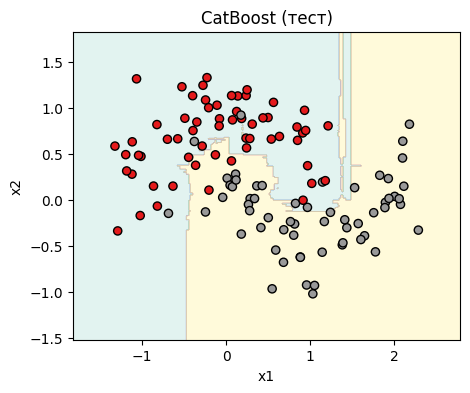

CatBoost: accuracy=0.917, precision=0.931, recall=0.900, f1=0.915


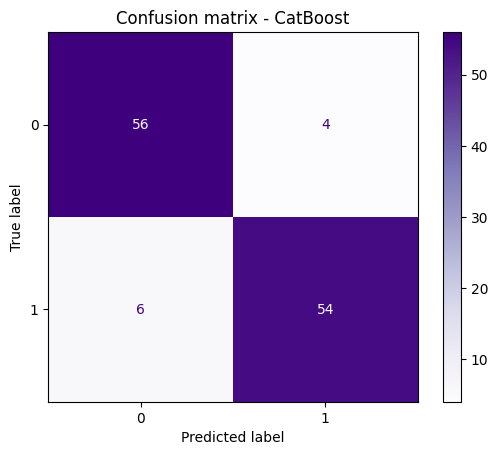

In [8]:
cat = CatBoostClassifier(
    iterations=300,       # число деревьев
    depth=6,              # глубина деревьев
    learning_rate=0.1,    # скорость обучения
    random_state=42,
    verbose=False
)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test).astype(int).ravel()

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_decision_boundary(ax, cat, X_test, y_test, title="CatBoost (тест)")
plt.show()

print_binary_metrics(y_test, y_pred_cat, name="CatBoost")

ConfusionMatrixDisplay.from_estimator(cat, X_test, y_test, cmap="Purples")
plt.title("Confusion matrix - CatBoost")
plt.show()

### Мультиклассовая классификация

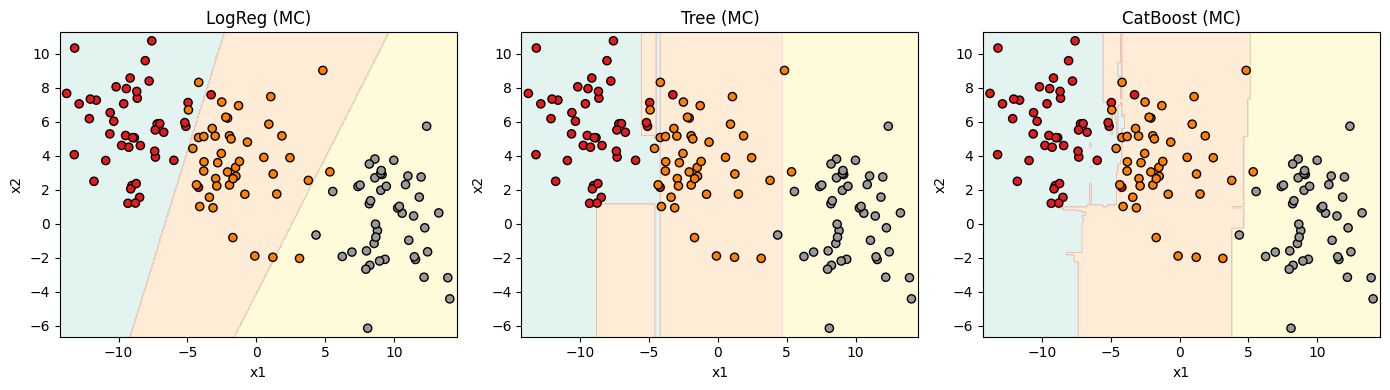

LogReg (MC): accuracy=0.956, macro-F1=0.955
Tree (MC): accuracy=0.926, macro-F1=0.926
CatBoost (MC): accuracy=0.963, macro-F1=0.963


In [9]:
from sklearn.metrics import f1_score
from sklearn.datasets import make_blobs


X3, y3 = make_blobs(n_samples=450, centers=3, cluster_std=2.3, random_state=7)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42, stratify=y3)

# 1) Логистическая регрессия (мультикласс)
logreg_mc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver='lbfgs', random_state=42)) # multi_class='multinomial'
])
logreg_mc.fit(X3_train, y3_train)

# 2) Дерево решений
tree_mc = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_mc.fit(X3_train, y3_train)

# 3) CatBoost (мультикласс)
cat_mc = CatBoostClassifier(
    iterations=300, depth=6, learning_rate=0.1,
    loss_function='MultiClass',
    random_state=42, verbose=False
)
cat_mc.fit(X3_train, y3_train)

models = [("LogReg (MC)", logreg_mc), ("Tree (MC)", tree_mc), ("CatBoost (MC)", cat_mc)]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, (name, model) in zip(axes, models):
    plot_decision_boundary(ax, model, X3_test, y3_test, title=name)
plt.tight_layout()
plt.show()

for name, model in models:
    y_pred = model.predict(X3_test)
    acc = accuracy_score(y3_test, y_pred)
    f1m = f1_score(y3_test, y_pred, average='macro')
    print(f"{name}: accuracy={acc:.3f}, macro-F1={f1m:.3f}")

Наблюдения:
- Логистическая регрессия проводит примерно линейные границы между классами.
- Дерево решений даёт "ступенчатые" границы.
- CatBoost чаще даёт более гладкую и качественную границу.

## Заключение

- Нужна простая, быстрая и базовая модель $-$ логистическая регрессия.
- Нужна интерпретируемость и нелинейность $-$ дерево решений (или случайный лес).
- Нужна высокая точность «из коробки» $-$ CatBoost/градиентный бустинг.

Не забывайте:
- Разделять данные на train/test, использовать [кросс-валидацию](https://education.yandex.ru/handbook/ml/article/kross-validaciya).
- Следить за дисбалансом классов
- Настраивать гиперпараметры

## Ссылки для дальнейшего изучения

Документация и учебники:
- Scikit-learn (классификация): https://scikit-learn.org/stable/supervised_learning.html
- Метрики классификации (sklearn): https://scikit-learn.org/stable/modules/model_evaluation.html
- CatBoost (официальная документация): https://catboost.ai/
- Учебник по ML (рус.): https://ml-handbook.ru/ (конспекты и практики)
- Курс «Введение в машинное обучение» (ВШЭ, рус.): https://www.coursera.org/learn/vvedenie-mashinnoe-obuchenie
- Визуальный playground для ML: https://ml-playground.com/ или https://playground.tensorflow.org/

Практика и визуализация:
- Примеры sklearn datasets: https://scikit-learn.org/stable/datasets/sample_generators.html
- Матрица ошибок и метрики: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
- Boosting (обзор): https://xgboost.readthedocs.io/en/stable/tutorials/model.html (для общего понимания бустинга)